## Libraries

In [1]:
# General Packages
import pandas as pd
import numpy as np
import os, json, zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from google.colab import drive

In [2]:
# Mount Drive on Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Install TF Official Models for BERT
!pip install -q tf-models-official

In [5]:
# For BERT Models
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from keras import metrics
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Benchmarks
import sklearn
from sklearn import model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score

In [ ]:
# Data Cleaning 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
import re, string

In [7]:
# To see all the columns in a dataframe 
pd.set_option('display.max_columns', None)

### Read the Dataset

The paths to the pre-trained model directories saved on our Google Drive account are specified below. You can find the links to download the pre-trained BERT models in "BERT Models - Fine Tuning on Tensorflow" section below, store in your preference of storage (on PC, Google Drive, etc.) and can read the files accordingly. We did not directly store and open them on Google Colab because of the limited disk space.

In [4]:
# Base Drive directory 
base_dir = '/content/drive/My Drive'


# Subdirectories of pre-trained BERT models
model_dir = os.path.join(base_dir, 'Models')

bert_tf_dir = os.path.join(model_dir, '01 TF BERT/BERT Base') # Pre-trained uncased BERT-Base model
bert_large_dir = os.path.join(model_dir, '01 TF BERT/BERT Large') # Pre-trained uncased BERT-Large model

bert_patents_model = os.path.join(model_dir, '02 BERT Google Patents/Model') # BERT-Large model pre-trained on the patent corpus

The "data.csv" obtained after the data collection is stored in "data.zip" file. To start the analysis, one can directly read the final labeled dataset from the zip file on the [GitHub repository](https://github.com/Humboldt-WI/dissertations/tree/main/Firm_performance_patent_NLP).

In [ ]:
# Get the GitHub links of zip data files to upload them on Colab
!wget https://github.com/Humboldt-WI/dissertations/blob/main/Firm_performance_patent_NLP/data.zip

In [11]:
# Base Colab directory
base_colab = '/content'

# Subdirectories of the dataset parts
zip_data = os.path.join(base_colab, 'data.zip')

In [12]:
# Open the zip files
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall(base_colab)  

In [13]:
# Read the csv files
df = pd.read_csv('/content/data.csv')

## Data Preparation

### Data Cleaning

In [ ]:
df['title'] = df['title'].astype(str).str.strip()
df['abstract'] = df['abstract'].astype(str).str.strip()

In [ ]:
df['title_abstract'] = df[['title', 'abstract']].apply(lambda x: ''.join(x), axis=1)
df['abstract_title'] = df[['abstract', 'title']].apply(lambda x: ''.join(x), axis=1)

In [ ]:
df['abstract_title'] = df['abstract_title'].astype(str).str.strip()
df['title_abstract'] = df['title_abstract'].astype(str).str.strip()

In [ ]:
# Clean Sentences
def clean_sentences(text):
    
    ## Remove punctuation
    text = text.translate(string.punctuation) 

    ## Clean the text ##took from kaggle and edited acc to common subjects https://www.kaggle.com/currie32/the-importance-of-cleaning-text and adjusted to our case
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\ s ", " ", text)
    text = re.sub(r"\ ve", " have ", text)
    text = re.sub(r"can t ", "cannot ", text)
    text = re.sub(r"n t ", " not ", text)
    text = re.sub(r"i m ", "i am", text)
    text = re.sub(r"\ re", " are ", text)
    text = re.sub(r"\ ll", " will ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" e mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r" ai ", "artificial intelligence", text)
    text = re.sub(r" nn ", "neural networks", text)
    text = re.sub(r" rnn ", "recurrent neural networks", text)
    text = re.sub(r" ml ", "machine learning", text)
    text = re.sub(r" vr ", "virtual reality", text)
    text = re.sub(r" tech ", "technology", text)
    text = re.sub(r"chatbot", "chat bot", text)
    text = re.sub(r"chatbots", "chat bots", text)
    text = re.sub(r"internet of things", "iot", text)
    text = re.sub(r" dl ", "deep learning", text)
    text = re.sub(r" ux ", "user experience", text)
    text = re.sub(r" nlp ", "natural language processing", text)    
    text = re.sub(r" also ", "", text)    
    text = re.sub(r" well ", "", text)    
    text = re.sub(r" are ", "", text)    
    text = re.sub(r" the ", "", text)    
    text = re.sub(r" et ", "", text)    
    text = re.sub(r" al ", "", text)    
    text = re.sub(r" eg ", "", text)    
    text = re.sub(r" nan ", "", text)
    text = re.sub(r" i ", "", text)  
    text = re.sub(r" a ", "", text)

    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop 
    text = [w for w in text if not w in stops and len(w) >= 2]
    text = " ".join(text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [ ]:
stops = stopwords.words('english')

In [ ]:
df['abstract']= df['abstract'].map(lambda x: clean_sentences(x))
df['title']= df['title'].map(lambda x: clean_sentences(x))
df['abstract_title']= df['abstract_title'].map(lambda x: clean_sentences(x))
df['title_abstract']= df['title_abstract'].map(lambda x: clean_sentences(x))

### Label Preparation

In [ ]:
# Select only granted companies - only for Granted Patents Discussion 6.1
# df = df[df['grant_date'] != "0"]

In [ ]:
# Select companies with at least 50 green patents
col = 'company'  
n = 50

df = df[df.groupby(col)[col].transform('count').ge(n)]

In [ ]:
# Drop observations without total assets change for 9 years
df.dropna(subset = ['total_assets_label_9'], inplace=True)
df.reset_index(drop=True)

In [ ]:
# Drop observations in which total assets did not change in 9 years
df = df[df['total_assets_label_9'] != 0]

In [ ]:
# Replace negative observation label -1 with 0 for practical binary labels of 0-1
df['total_assets_label_9'] = df['total_assets_label_9'].replace(-1, 0)

In [ ]:
# Get a random sample of the dataset equal to 9-year time lag, if time lag is 3 or 5
df = df.sample(n=4672, random_state=12) # n=4672 for assets, 4669 for revenues

In [ ]:
# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.25, random_state=12)

## BERT Models - Fine Tuning on Tensorflow

### Standard BERT Models

The pre-trained BERT Models proposed by [Devlin et al. (2018)](https://arxiv.org/pdf/1810.04805.pdf) can be downloaded [here](https://github.com/google-research/bert).

In [ ]:
# Gather the patent text and the label for train and test sets
train_df = train[['abstract_title','total_assets_label_9']]
test_df = test[['abstract_title','total_assets_label_9']]

In [9]:
# List the files in BERT model folder
tf.io.gfile.listdir(bert_tf_dir) # Choose "bert_large_dir" folder for BERT-Large

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [10]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(bert_tf_dir, "vocab.txt"), # Choose "bert_large_dir" folder for BERT-Large
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
def bert_encode(texts, tokenizer, max_len=512): # max_len=256 for BERT-Large
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts['abstract_title']:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return tf.constant(np.array(all_tokens)), tf.constant(np.array(all_masks)), tf.constant(np.array(all_segments))

In [ ]:
train_tokens = bert_encode(train_df, tokenizer)
train_labels = train_df['total_assets_label_9']

test_tokens = bert_encode(test_df, tokenizer)
test_labels = test_df['total_assets_label_9']

In [ ]:
train_tokens = {'input_word_ids': train_tokens[0],
                'input_mask': train_tokens[1],
                'input_type_ids': train_tokens[2]}

test_tokens = {'input_word_ids': test_tokens[0],
               'input_mask': test_tokens[1],
               'input_type_ids': test_tokens[2]}            

In [ ]:
train_labels = tf.constant(train_labels)
test_labels = tf.constant(test_labels)

In [11]:
# Model Configurations 
bert_config_file = os.path.join(bert_tf_dir, "bert_config.json") # Choose "bert_large_dir" folder for BERT-Large
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
# BERT Classifier
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

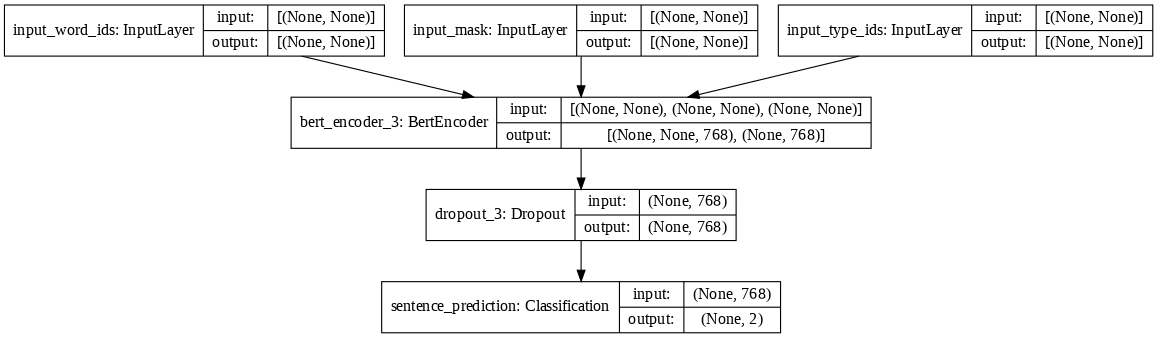

In [ ]:
# Plot the shape of BERT Classifier
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=80)

In [ ]:
# Restore checkpoints 
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(os.path.join(bert_tf_dir, 'bert_model.ckpt')) # Choose "bert_large_dir" folder for BERT-Large

In [ ]:
# Set up epochs and steps
epochs = 4
batch_size = 8
eval_batch_size = 8

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# Create an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Print the type of the optimizer
type(optimizer)

In [ ]:
# Custom metrics for the model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Compile and fit the model
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32), f1_score, precision_m, recall_m] 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
earlyStopping = [EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)]


bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = bert_classifier.fit(
      train_tokens, train_labels,
      validation_data=(test_tokens, test_labels),
      batch_size=batch_size,
      epochs=epochs,
      callbacks = earlyStopping)

In [ ]:
# Model history
history.history

In [ ]:
# Train results
results_train = bert_classifier.evaluate(train_tokens, train_labels,
      batch_size=batch_size)
print("train loss, train acc, train_f1, train_precision, train_recall:", results_train)

In [ ]:
# Test results
results = bert_classifier.evaluate(test_tokens, test_labels,
      batch_size=batch_size)
print("test loss, test acc, test_f1, test_precision, test_recall:", results)

In [ ]:
# Generate predictions 
print("Generate predictions")
predictions = bert_classifier.predict(test_tokens)
print("Predictions Shape:", predictions.shape)

### BERT Models for Patents

The BERT models pre-trained on the patent corpus by [Srebrovic and Yonamine (2020)](https://services.google.com/fh/files/blogs/bert_for_patents_white_paper.pdf) can be downloaded [here](https://github.com/google/patents-public-data/blob/master/models/BERT%20for%20Patents.md).

In [ ]:
# Gather the patent text and the label for train and test sets
train_df = train[['abstract_title','total_assets_label_9']]
test_df = test[['abstract_title','total_assets_label_9']]

In [12]:
# List the files in BERT model folder
tf.io.gfile.listdir(bert_patents_model) 

['vocab.txt',
 'saved_model.pb',
 'variables.data-00000-of-00001',
 'variables.index',
 'bert_for_patents_large_config.json']

In [13]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(bert_patents_model, "vocab.txt"), 
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 39859


In [ ]:
def bert_encode(texts, tokenizer, max_len=512): # max_len=256 for the large model
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts['abstract_title']:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return tf.constant(np.array(all_tokens)), tf.constant(np.array(all_masks)), tf.constant(np.array(all_segments))

In [ ]:
train_tokens = bert_encode(train_df, tokenizer)
train_labels = train_df['total_assets_label_9']

test_tokens = bert_encode(test_df, tokenizer)
test_labels = test_df['total_assets_label_9']

In [ ]:
train_tokens = {'input_word_ids': train_tokens[0],
                'input_mask': train_tokens[1],
                'input_type_ids': train_tokens[2]}

test_tokens = {'input_word_ids': test_tokens[0],
               'input_mask': test_tokens[1],
               'input_type_ids': test_tokens[2]}            

In [ ]:
train_labels = tf.constant(train_labels)
test_labels = tf.constant(test_labels)

In [ ]:
# Model Configurations of the Large Model
bert_config_file = os.path.join(bert_patents_model, "bert_for_patents_large_config.json") 
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 1024,
 'initializer_range': 0.02,
 'intermediate_size': 4096,
 'max_position_embeddings': 512,
 'num_attention_heads': 16,
 'num_hidden_layers': 24,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
# Model Configurations of the Base Model - manually written since it the bert_for_patents_large_config.json file has configurations for large model
config_dict = {'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 39859}

bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [ ]:
# BERT Classifier
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [ ]:
# Plot the shape of BERT Classifier
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=80)

In [ ]:
# Restore checkpoints 
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(os.path.join(bert_patents_model, 'variables'))

In [ ]:
# Set up epochs and steps
epochs = 4
batch_size = 8
eval_batch_size = 8

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# Create an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Print the type of the optimizer
type(optimizer)

In [ ]:
# Custom metrics for the model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Compile and fit the model
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32), f1_score, precision_m, recall_m] 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
earlyStopping = [EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)]


bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = bert_classifier.fit(
      train_tokens, train_labels,
      validation_data=(test_tokens, test_labels),
      batch_size=batch_size,
      epochs=epochs,
      callbacks = earlyStopping)

In [ ]:
# Model history
history.history

In [ ]:
# Train results
results_train = bert_classifier.evaluate(train_tokens, train_labels,
      batch_size=batch_size)
print("train loss, train acc, train_f1, train_precision, train_recall:", results_train)

In [ ]:
# Test results
results = bert_classifier.evaluate(test_tokens, test_labels,
      batch_size=batch_size)
print("test loss, test acc, test_f1, test_precision, test_recall:", results)

In [ ]:
# Generate predictions 
print("Generate predictions")
predictions = bert_classifier.predict(test_tokens)
print("Predictions Shape:", predictions.shape)

In [ ]:
# Draw Accuracy & Loss Graph
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Draw the final F1 Scores  for total assets prediction based on 9-year time lag
scores=['F1 Score'] 
y1=[0.9284]
y2=[0.9319]
y3=[0.9319]
y4=[0.9319]
y5=[0.9451]
y6=[0.9388]

fig = go.Figure(data=[
    go.Bar(name='BERT-Base', x=scores, y=y1),
    go.Bar(name='BERT-Base for Patents', x=scores, y=y2),
    go.Bar(name='BERT-Large', x=scores, y=y3),
    go.Bar(name='BERT-Large for Patents', x=scores, y=y4),
    go.Bar(name='SVM', x=scores, y=y5),
    go.Bar(name='Naive Bayes', x=scores, y=y6)])
# Change the bar mode

texts = [y1,y2,y3,y4,y5,y6]
for i, t in enumerate(texts):
    fig.data[i].text = t
    fig.data[i].textposition = 'inside'
    fig.update_layout(barmode='group', template="plotly_white", width=700)
fig.show()

## Benchmarks

In [ ]:
# Gather the patent text and the label for train and test sets
Train_X = train['abstract_title']
Train_Y = train['total_assets_label_9']

Test_X = test['abstract_title']
Test_Y = test['total_assets_label_9']

In [ ]:
# Label encode the target variable 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
# Vectorize the words by using TF-IDF Vectorizer 
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB_test = Naive.predict(Test_X_Tfidf)

# predict the labels on validation dataset
predictions_NB_train = Naive.predict(Train_X_Tfidf)

In [ ]:
# NB Scores

# Accuracy Score
print("NB Train Accuracy Score -> ", accuracy_score(Train_Y, predictions_NB_train))
print("NB Test Accuracy Score -> ", accuracy_score(Test_Y, predictions_NB_test))

# F1 Score
print("NB Train F1 Score -> ", f1_score(Train_Y, predictions_NB_train))
print("NB Test F1 Score -> ", f1_score(Test_Y, predictions_NB_test)) 

# Precision Score
print("NB Train Precision Score -> ", precision_score(Train_Y, predictions_NB_train)) 
print("NB Test Precision Score -> ", precision_score(Test_Y, predictions_NB_test)) 

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM_test = SVM.predict(Test_X_Tfidf)

# predict the labels on validation dataset
predictions_SVM_train = SVM.predict(Train_X_Tfidf)

In [ ]:
# SVM Scores

# Accuracy Score
print("SVM Train Accuracy Score -> ", accuracy_score(Train_Y, predictions_SVM_train))
print("SVM Test Accuracy Score -> ", accuracy_score(Test_Y, predictions_SVM_test))

# F1 Score
print("SVM Train F1 Score -> ", f1_score(Train_Y, predictions_SVM_train)) 
print("SVM Test F1 Score -> ", f1_score(Test_Y, predictions_SVM_test))

# Precision Score
print("SVM Train Precision Score -> ", precision_score(Train_Y, predictions_SVM_train)) 
print("SVM Test Precision Score -> ", precision_score(Test_Y, predictions_SVM_test)) 

## Discussion 

### Granted patents

In [65]:
# Select only granted patents
df = df[df['grant_date'] != 0]

In [68]:
# Convert the columns into datetime
df['filing_date'] = pd.to_datetime(df['filing_date'].astype(str).str.strip())
df['grant_date'] = pd.to_datetime(df['grant_date'].astype(str).str.strip())

In [70]:
# Create grant lag column
df['grant_lag'] = df['grant_date'] - df['filing_date']

In [72]:
# Convert grant lag from days to years
df['grant_lag'] = df.grant_lag / np.timedelta64(1, 'Y')
df['grant_lag'] = round(df['grant_lag'],ndigits=1)

In [73]:
# Grant lag distribution
df['grant_lag'].describe()

count    6240.000000
mean        5.593141
std         2.473068
min         1.000000
25%         3.600000
50%         5.100000
75%         7.100000
max        18.600000
Name: grant_lag, dtype: float64

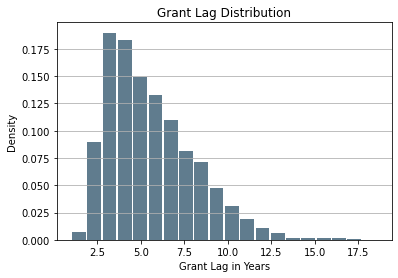

In [76]:
df.grant_lag.plot.hist(grid=True, bins=20, rwidth=0.9, density=True,
                   color='#607c8e')
plt.title('Grant Lag Distribution')
plt.xlabel('Grant Lag in Years')
plt.ylabel('Density')
plt.grid(axis='x')

### Data Preparation for Causality Analysis

In [5]:
# Drop multiple patent publications
df = df.drop_duplicates(subset=['publication_number'], keep='first', ignore_index=True)

In [6]:
# Create a new column of patent publication year
df['publication_date'] = pd.to_datetime(df['publication_date'])
df['year'] = df['publication_date'].dt.year

In [7]:
# Gather total number of published patents per company per year
patent_count = pd.DataFrame(df[['company', 'year']].value_counts()).reset_index()
patent_count.columns = ['company','year', 'num_patents']
patent_count.head()

,company,year,num_patents
0,UNITED TECHNOLOGIES CORP,2016,781
1,GEN ELECTRIC,2017,672
2,TOYOTA MOTOR CO LTD,2013,600
3,GEN ELECTRIC,2012,595
4,TOYOTA MOTOR CO LTD,2014,546


In [ ]:
# Create a dataset only with financial columns and company name
df_fin = df[['company', 'total_rev_2010', 'total_rev_2011', 'total_rev_2012','total_rev_2013' ,'total_rev_2014' ,'total_rev_2015' ,'total_rev_2016',
              'total_rev_2017', 'total_rev_2018', 'total_rev_2019', 'total_assets_2010', 'total_assets_2011', 'total_assets_2012', 'total_assets_2013',
              'total_assets_2014', 'total_assets_2015', 'total_assets_2016', 'total_assets_2017', 'total_assets_2018', 
             'total_assets_2019']].drop_duplicates(subset=['company'], keep='first', ignore_index=True)           

In [9]:
# Merge yearly patent counts with the financial data
patent_causality = pd.merge(patent_count, df_fin, on='company', how='left') 
patent_causality.head() 

,company,year,num_patents,total_rev_2010,total_rev_2011,total_rev_2012,total_rev_2013,total_rev_2014,total_rev_2015,total_rev_2016,total_rev_2017,total_rev_2018,total_rev_2019,total_assets_2010,total_assets_2011,total_assets_2012,total_assets_2013,total_assets_2014,total_assets_2015,total_assets_2016,total_assets_2017,total_assets_2018,total_assets_2019
0,UNITED TECHNOLOGIES CORP,2016,781,38984.08,42916.64,43768.63,41100.09,47834.09,51652.23,54227.24,49832.25,58081.97,68655.69,43621.15,47302.68,67812.26,65784.83,75349.84,80550.89,84978.49,80714.98,117219.89,124500.93
1,GEN ELECTRIC,2017,672,NaN,NaN,NaN,NaN,628.29,851.76,876.98,804.92,NaN,NaN,NaN,NaN,NaN,NaN,1043.43,1490.01,8676.31,8301.33,NaN,NaN
2,TOYOTA MOTOR CO LTD,2013,600,149951.23,161629.14,169160.63,182812.25,181116.13,211278.06,221959.40,231469.91,224540.72,243038.38,240141.39,253741.38,279005.24,293996.03,292115.08,370275.13,370628.36,408889.46,384494.17,417614.15
3,GEN ELECTRIC,2012,595,NaN,NaN,NaN,NaN,628.29,851.76,876.98,804.92,NaN,NaN,NaN,NaN,NaN,NaN,1043.43,1490.01,8676.31,8301.33,NaN,NaN
4,TOYOTA MOTOR CO LTD,2014,546,149951.23,161629.14,169160.63,182812.25,181116.13,211278.06,221959.40,231469.91,224540.72,243038.38,240141.39,253741.38,279005.24,293996.03,292115.08,370275.13,370628.36,408889.46,384494.17,417614.15


#### Asset Causality

In [10]:
# Select only asset columns
asset_causality = patent_causality[['company', 'year', 'num_patents','total_assets_2010', 'total_assets_2011', 'total_assets_2012', 'total_assets_2013',
              'total_assets_2014', 'total_assets_2015', 'total_assets_2016', 'total_assets_2017', 'total_assets_2018', 'total_assets_2019']]
asset_causality.columns = asset_causality.columns.str.replace('total_assets_','')              
asset_causality.head()              

,company,year,num_patents,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,UNITED TECHNOLOGIES CORP,2016,781,43621.15,47302.68,67812.26,65784.83,75349.84,80550.89,84978.49,80714.98,117219.89,124500.93
1,GEN ELECTRIC,2017,672,NaN,NaN,NaN,NaN,1043.43,1490.01,8676.31,8301.33,NaN,NaN
2,TOYOTA MOTOR CO LTD,2013,600,240141.39,253741.38,279005.24,293996.03,292115.08,370275.13,370628.36,408889.46,384494.17,417614.15
3,GEN ELECTRIC,2012,595,NaN,NaN,NaN,NaN,1043.43,1490.01,8676.31,8301.33,NaN,NaN
4,TOYOTA MOTOR CO LTD,2014,546,240141.39,253741.38,279005.24,293996.03,292115.08,370275.13,370628.36,408889.46,384494.17,417614.15


In [11]:
# Convert the dataset into a panel data structure
asset_causality = asset_causality.melt(id_vars=['company', 'year', 'num_patents'], value_name='total_assets')
asset_causality.head()

,company,year,num_patents,variable,total_assets
0,UNITED TECHNOLOGIES CORP,2016,781,2010,43621.15
1,GEN ELECTRIC,2017,672,2010,NaN
2,TOYOTA MOTOR CO LTD,2013,600,2010,240141.39
3,GEN ELECTRIC,2012,595,2010,NaN
4,TOYOTA MOTOR CO LTD,2014,546,2010,240141.39


In [12]:
# Keep only the total assets based on the given year - e.g. delete patent of 2010 with total assets value for 2011, 2012, etc. and keep only for 2010
asset_causality['variable'] = asset_causality['variable'].astype(int)
asset_causality = asset_causality.loc[asset_causality['year'] == asset_causality['variable']].drop('variable',1)
asset_causality = asset_causality.dropna().reset_index().drop('index',1)
asset_causality.head()

,company,year,num_patents,total_assets
0,TOYOTA MOTOR CO LTD,2010,454,240141.39
1,SIEMENS AG,2010,251,102827.00
2,BOSCH GMBH ROBERT,2010,176,5579.71
3,PANASONIC CORP,2010,171,66133.86
4,HONDA MOTOR CO LTD,2010,143,92016.39


In [ ]:
# Select companies with at least 9 year of green patents
asset_causality_min_9_50 = asset_causality[asset_causality.groupby('company')['company'].transform('size') > 8].reset_index().drop('index',1)

In [ ]:
# Select companies with at least 10 year of green patents
asset_causality_min_10_50 = asset_causality[asset_causality.groupby('company')['company'].transform('size') > 9].reset_index().drop('index',1)

We created 4 datasets based on total assets and total revenues for the analysis: 
1.   Minimum 9 years of patent activity and minimum 1 patent publication 
2.   Minimum 9 years of patent activity and minimum 50 patent publications 
3.   Minimum 10 years of patent activity and minimum 1 patent publication 
4.   Minimum 10 years of patent activity and minimum 50 patent publications 

In this section we only give one example of each 9 year and 10 year patent activities. By selecting the dataframe "df" based on the number of patent publications, as shown in "Label Preparation" section, you could gather all 4 files for the causality analysis. Same applies to the revenue datasets for the causal analysis below.

In [ ]:
# Save the data for Panel Granger Causality Analysis on R
asset_causality_min_9_50.to_csv('asset_causality_min_9_50.csv', index=False)
asset_causality_min_10_50.to_csv('asset_causality_min_10_50.csv', index=False)

#### Revenue Causality

In [13]:
# Select only revenue columns
rev_causality = patent_causality[['company', 'year', 'num_patents','total_rev_2010', 'total_rev_2011', 'total_rev_2012','total_rev_2013' ,'total_rev_2014' ,'total_rev_2015' ,'total_rev_2016',
              'total_rev_2017', 'total_rev_2018', 'total_rev_2019']]
rev_causality.columns = rev_causality.columns.str.replace('total_rev_','')              
rev_causality.head()              

,company,year,num_patents,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,UNITED TECHNOLOGIES CORP,2016,781,38984.08,42916.64,43768.63,41100.09,47834.09,51652.23,54227.24,49832.25,58081.97,68655.69
1,GEN ELECTRIC,2017,672,NaN,NaN,NaN,NaN,628.29,851.76,876.98,804.92,NaN,NaN
2,TOYOTA MOTOR CO LTD,2013,600,149951.23,161629.14,169160.63,182812.25,181116.13,211278.06,221959.40,231469.91,224540.72,243038.38
3,GEN ELECTRIC,2012,595,NaN,NaN,NaN,NaN,628.29,851.76,876.98,804.92,NaN,NaN
4,TOYOTA MOTOR CO LTD,2014,546,149951.23,161629.14,169160.63,182812.25,181116.13,211278.06,221959.40,231469.91,224540.72,243038.38


In [14]:
# Convert the dataset into a panel data structure
rev_causality = rev_causality.melt(id_vars=['company', 'year', 'num_patents'], value_name='total_rev')
rev_causality.head()

,company,year,num_patents,variable,total_rev
0,UNITED TECHNOLOGIES CORP,2016,781,2010,38984.08
1,GEN ELECTRIC,2017,672,2010,NaN
2,TOYOTA MOTOR CO LTD,2013,600,2010,149951.23
3,GEN ELECTRIC,2012,595,2010,NaN
4,TOYOTA MOTOR CO LTD,2014,546,2010,149951.23


In [15]:
# Keep only the total revenues based on the given year - e.g. delete patent of 2010 with total revenue value for 2011, 2012, etc. and keep only for 2010
rev_causality['variable'] = rev_causality['variable'].astype(int)
rev_causality = rev_causality.loc[rev_causality['year'] == rev_causality['variable']].drop('variable',1)
rev_causality = rev_causality.dropna().reset_index().drop('index',1)
rev_causality.head()

,company,year,num_patents,total_rev
0,TOYOTA MOTOR CO LTD,2010,454,149951.23
1,SIEMENS AG,2010,251,68828.00
2,BOSCH GMBH ROBERT,2010,176,173.10
3,PANASONIC CORP,2010,171,58695.42
4,HONDA MOTOR CO LTD,2010,143,67883.46


In [ ]:
# Select companies with at least 9 year of green patents
rev_causality_min_10_50 = rev_causality[rev_causality.groupby('company')['company'].transform('size') > 8].reset_index().drop('index',1)

In [ ]:
# Select companies with at least 10 year of green patents
rev_causality_min_10_50 = rev_causality[rev_causality.groupby('company')['company'].transform('size') > 9].reset_index().drop('index',1)

In [ ]:
# Save the data for Panel Granger Causality Analysis on R
rev_causality_min_9_50.to_csv('rev_causality_min_9_50.csv', index=False)
rev_causality_min_10_50.to_csv('rev_causality_min_10_50.csv', index=False)